## Задание 
Используя сверточные слои и архитектуру получите на fashion mnist качество не ниже 89,5%

In [1]:
import numpy as np
import torch
from torch import nn
import torchvision as tv
from torchvision import datasets
from torchvision.transforms import ToTensor
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 256

In [3]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

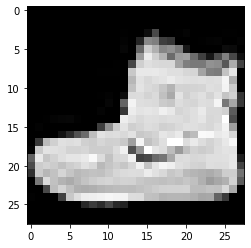

In [4]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray')

In [5]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [6]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, kernel_size=3, padding=2),
    torch.nn.Dropout(0.25),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(32, 64, kernel_size=3),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(2304, 1152),
    torch.nn.ReLU(),
    torch.nn.Linear(1152, 576),
    torch.nn.ReLU(),
    torch.nn.Linear(576, 10)
)

In [7]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 32, 30, 30])
Layer Dropout(p=0.25, inplace=False). X shape: torch.Size([1, 32, 30, 30])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 32, 15, 15])
Layer Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)). X shape: torch.Size([1, 64, 13, 13])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 64, 6, 6])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 2304])
Layer Linear(in_features=2304, out_features=1152, bias=True). X shape: torch.Size([1, 1152])
Layer ReLU(). X shape: torch.Size([1, 1152])
Layer Linear(in_features=1152, out_features=576, bias=True). X shape: torch.Size([1, 576])
Layer ReLU(). X shape: torch.Size([1, 576])
Layer Linear(in_features=576, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [8]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [9]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [10]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [11]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs)

epoch 1, loss 0.5355, train acc 0.800, test acc 0.853, time 91.0 sec
epoch 2, loss 0.3157, train acc 0.884, test acc 0.877, time 85.9 sec
epoch 3, loss 0.2665, train acc 0.900, test acc 0.894, time 86.5 sec
epoch 4, loss 0.2318, train acc 0.914, test acc 0.902, time 86.7 sec
epoch 5, loss 0.2029, train acc 0.924, test acc 0.904, time 86.8 sec
